In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import cv2
import math
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes

In [2]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)
print(torch.__version__)
print(torchvision.__version__)

# device = torch.device("cpu")

cuda NVIDIA GeForce GTX 1080 Ti
1.12.1+cu116
0.13.1+cu116


In [3]:
from dataset import MusicSheetDataSet
import random

def area(box):
    return (box[2] - box[0]) * (box[3] - box[1])

def crop(image, target, region, dataset):
    boxes = []
    labels = []
    for annotation in target:
        # print(annotation)
        orig_box = [x for x in annotation['a_bbox']]
        new_box = [
            max(orig_box[0], region[0]) - region[0],
            max(orig_box[1], region[1]) - region[1],
            min(orig_box[2], region[2]) - region[0],
            min(orig_box[3], region[3]) - region[1],
        ]

        if new_box[0] >= new_box[2] or new_box[1] >= new_box[3] or area(new_box) < area(orig_box) * 0.33:
            continue

        for cat_id in annotation['cat_id']:
            if (cat_id == None):
                continue

            category = dataset.get_category(cat_id)
            if (category['annotation_set'] != 'deepscores'):
                continue

            if (category['name'] in {'stem', 'ledgerLine'}):
                break
            # if (category['name'] in oneset):
            labels.append(int(cat_id))
            boxes.append(new_box)
    
    return (
        torch.tensor(image[region[1] : region[3], region[0] : region[2]]).div(255).unsqueeze(0),
        {
            'boxes': torch.tensor(boxes),
            'labels': torch.tensor(labels),
        }
    )

def transform(images, targets, dataset):
    image_res = []
    target_res = []
    for image, target in zip(images, targets):
        height, width = image.shape

        x = random.randrange(0, width // 2)
        y = random.randrange(0, height // 2)
        region = [x, y, x + width // 2, y + height // 2]

        i, t = crop(image, target, region, dataset)

        if t['boxes'].shape[0] == 0:
            region = [0, 0, width // 2, height // 2]
            i, t = crop(image, target, region, dataset)
        
        image_res.append(i)
        target_res.append(t)
    return image_res, target_res

dataset = MusicSheetDataSet("ds2_dense", "train")

In [4]:
class Label:
    def __init__(self, bbox=None, name=None, confidence=None, on_edge=False):
        self.bbox: list[float] = bbox
        self.name: str = name
        self.confidence: float = confidence
        self.on_edge: bool = on_edge
    
    def x_min(self):
        return self.bbox[0]
    
    def y_min(self):
        return self.bbox[1]
    
    def x_max(self):
        return self.bbox[2]
    
    def y_max(self):
        return self.bbox[3]
    
    def intersects(self, other) -> bool:
        return (self.x_max() >= other.x_min() and
                self.x_min() <= other.x_max() and
                self.y_max() >= other.y_min() and
                self.y_min() <= other.y_max())
    
    def intersection(self, other, result=None):
        if result == None:
            result = self
        elif self.confidence > other.confidence:
            result.name = self.name
            result.confidence = self.confidence
        else:
            result.name = other.name
            result.confidence = other.confidence
        
        result.bbox = [
            max(self.x_min(), other.x_min()),
            max(self.y_min(), other.y_min()),
            min(self.x_max(), other.x_max()),
            min(self.y_max(), other.y_max()),
        ]
        return result


    def union(self, other, result=None):
        if result == None:
            result = self
        elif self.confidence > other.confidence:
            result.name = self.name
            result.confidence = self.confidence
        else:
            result.name = other.name
            result.confidence = other.confidence

        result.bbox = [
            min(self.x_min(), other.x_min()),
            min(self.y_min(), other.y_min()),
            max(self.x_max(), other.x_max()),
            max(self.y_max(), other.y_max()),
        ]
        return result
    
    def copy(self, other=None):
        if other == None:
            other = Label(None, None, None)
        other.bbox = self.bbox.copy()
        other.name = self.name
        other.confidence = self.confidence
    
    def area(self):
        return (self.x_max() - self.x_min()) * (self.y_max() - self.y_min())
    
    def __repr__(self):
        return f"{self.name}"

class MusicSymbolDetector:
    def __init__(self):
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
            pretrained=True,
            num_classes=137,
            min_size=1024,
            max_size=1024,
            box_detections_per_img=300
        )

        params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = torch.optim.Adam(params)
        self.epoch = 0
        self.loss = 0
    
    def __call__(self, image):
        # TODO fix this confusing code

        self.model.to(device)
        self.model.eval()
        # split image into 6 smaller image for more accurate small object detection
        height, width = image.shape
        box_size = int(width * 0.55)

        results: list[Label] = []
        iou_threshold = 0.5
        edge_size = box_size * 0.05
        
        for y in [0, (height - box_size) // 2, height - box_size]:
            for x in [0, width - box_size]:
                edge_box = Label([x + edge_size, y + edge_size, x + box_size - edge_size, y + box_size - edge_size])

                # inference on each sub image
                i = torch.tensor(image[y : y + box_size, x : x + box_size]).div(255).unsqueeze_(0).to(device)
                result = self.model([i])[0]

                result["boxes"][:, (0, 2)] += x
                result["boxes"][:, (1, 3)] += y

                for box, label, score in zip(result["boxes"].detach().cpu(), result["labels"].detach().cpu(), result["scores"].detach().cpu()):
                    label = Label(
                        box.tolist(),
                        dataset.get_category(label.item())['name'],
                        score.item(),
                    )
                    label.on_edge = not label.intersects(edge_box)

                    for existing_label in results:
                        if not existing_label.intersects(label):
                            continue
                        if existing_label.on_edge:
                            results.remove(existing_label)
                            continue
                        if label.on_edge:
                            break # do not add to result

                        intersect = existing_label.intersection(label, Label())
                        union = existing_label.union(label, Label())

                        if intersect.area() / union.area() > iou_threshold:
                            if existing_label.confidence > label.confidence:
                                break # do not add to result
                            else: # label.confidence > existing_label.confidence
                                results.remove(existing_label)
                    else:
                        results.append(label)
        
        return results
    
    def save(self, path):
        torch.save({
            "model": self.model.state_dict(),
            "optimizer": self.optimizer.state_dict(),
            "epoch": self.epoch,
            "loss": self.loss,
        }, path)

    def load(self, path = None):
        if path == None:
            path = self
            self = MusicSymbolDetector()
        
        data = torch.load(path)
        self.model.load_state_dict(data['model'])
        self.optimizer.load_state_dict(data['optimizer'])
        current_epoch = data['epoch']
        
        print("loaded model at epoch: {}, loss: {}".format(current_epoch, data['loss']))

        # move optimizer to cuda
        for state in self.optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)

        return self
    
    def train(self, dataset : MusicSheetDataSet, epochs : int = 1, transform = None):
        self.model.to(device)
        self.model.train()
        torch.cuda.empty_cache()

        data_count = len(dataset)

        for _ in range(epochs):
            all_losses = 0
            all_losses_dict = {}

            dataloader = DataLoader(
                dataset,
                collate_fn=lambda x : zip(*x),
                shuffle = True
            )

            for images, targets in tqdm(dataloader):
                if transform != None:
                    images, targets = transform(images, targets, dataset)
                
                images = [image.to(device) for image in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                self.optimizer.zero_grad(set_to_none=True)

                loss_dict: dict[str, torch.Tensor] = self.model(images, targets) # the model computes the loss automatically if we pass in targets

                losses: torch.Tensor = sum(loss for loss in loss_dict.values())

                loss_value = losses.item()
                all_losses += loss_value
                
                for k, v in loss_dict.items():
                    if k not in all_losses_dict:
                        all_losses_dict[k] = 0
                    all_losses_dict[k] += v
                
                if not math.isfinite(loss_value):
                    print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
                    print(loss_dict)
                    sys.exit(1)
                
                losses.backward()
                
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1)
                self.optimizer.step()
            
            self.epoch += 1
            self.loss = all_losses / data_count
            print("Epoch {:>3}, lr: {:.6f}, loss: {:.6f}, {}".format(
                self.epoch,
                self.optimizer.param_groups[0]['lr'], 
                self.loss,
                ', '.join("{}: {:.6f}".format(k, v / data_count) for k, v in all_losses_dict.items()),
            ))

            self.save(f"model/{self.epoch}")


In [5]:
# detector = MusicSymbolDetector()
# detector.train(dataset, 50, transform)

In [6]:
detector = MusicSymbolDetector.load("model/50")

loaded model at epoch: 50, loss: 0.26688769506358934


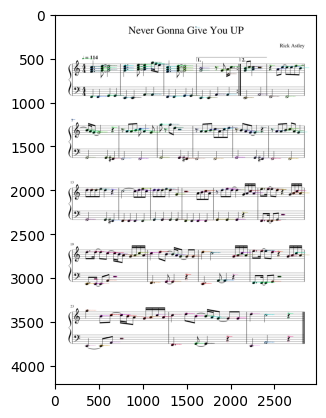

In [7]:
# img = cv2.imread("ds2_dense/images/lg-900267602436792595-aug-gutenberg1939--page-4.png", cv2.IMREAD_GRAYSCALE)
img = cv2.imread("sheets/never gonna give you up.png", cv2.IMREAD_GRAYSCALE)

res = detector(img)

boxes = []
labels = []

for label in res:
    if "note" in label.name or 'rest' in label.name:
        boxes.append(label.bbox)
        labels.append(label.name)

plt.imshow(draw_bounding_boxes(torch.tensor(img).unsqueeze(0), torch.tensor(boxes), labels).moveaxis(0, 2))
plt.savefig("img.png", dpi=800)



In [8]:

list_res = []
for label in res:
    list_res.append({
        "bbox": label.bbox,
        "name": label.name,
        "confidence": label.confidence
    })

import json
with open("nggup2.json", 'w') as f:
    f.write(json.dumps(list_res))